In [12]:
from moseq2_detectron_extract.model.model import MoseqDatasetMapper
import os

from moseq2_detectron_extract.model.config import (add_dataset_cfg,
                                                   get_base_config,
                                                   load_config)
from moseq2_detectron_extract.io.annot import (
    default_keypoint_names,
    get_dataset_statistics, read_annotations, register_dataset_metadata,
    register_datasets, replace_data_path_in_annotations, show_dataset_info,
    validate_annotations)


from albumentations.augmentations.transforms import GaussNoise, RandomFog
from albumentations.augmentations.geometric.transforms import Perspective  
from moseq2_detectron_extract.model.augmentations import Albumentations, RandomFieldNoiseAugmentation, ScaleAugmentation, ParticleNoiseAugmentation
from detectron2.data.transforms.augmentation_impl import RandomBrightness, RandomContrast, RandomRotation, ResizeScale,FixedSizeCrop
from detectron2.data.transforms import (Augmentation, BlendTransform,
                                        NoOpTransform, Transform, ResizeTransform, TransformList, CropTransform)
from detectron2.data import build_detection_train_loader
import itertools
import matplotlib.pyplot as plt
import numpy as np
from detectron2.data import transforms as T
import random
from PIL import Image
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import ImageGrid


def plot_tri_channel(frame, labels=None):
    if labels is None:
        labels = []

    fig = plt.figure(figsize=(24, 6))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), cbar_mode='each', axes_pad=0.4, share_all=True,)

    for i, (ax, cax, label) in enumerate(itertools.zip_longest(grid, grid.cbar_axes, labels, fillvalue="")):
        if i < 3:
            im = ax.imshow(frame[:, :, i])
            cax.colorbar(im)
        else:
            im = ax.imshow(frame)

        ax.set_title(label)



In [2]:
# model_dir = r'C:\Users\thackray\git\moseq2-detectron-extract\notebooks\models\2021-09-28_big_model\2021-10-05T13-56_51'
model_dir = r'C:\Users\Josh\git\moseq2\moseq2-detectron-extract\notebooks\models\2021-09-28_big_model\2021-10-20T16-16_35'
annot_file = [
    #"C:\\Users\\thackray\\moseq-detectron-data\\2021-09-15_sci-dataset-big-annotated-keypoints-masks\\project-3-at-2022-02-19-19-24-fe2ed492.json",
    #"C:\\Users\\thackray\\moseq-detectron-data\\moseq-mask-keypoints-annot\\result.json",
    "E:\\moseq_raw_data\\detectron2_testing\\2021-09-15_sci-dataset-big-annotated-keypoints-masks\\project-3-at-2021-09-16-21-07-30920741.json",
]
replace_data_path = [
    ("/data/local-files/?d=Moseq-SCI-Detectron/images/", "E:\\moseq_raw_data\\detectron2_testing\\2021-09-15_sci-dataset-big-annotated-keypoints-masks\\sci-dataset\\images\\"),
    ("/data/local-files/?d=Moseq-SCI-Detectron/images/", "C:\\Users\\thackray\\moseq-detectron-data\\2021-09-15_sci-dataset-big-annotated-keypoints-masks\\sci-dataset\\images\\"),
    ("images/", "C:\\Users\\thackray\\moseq-detectron-data\\moseq-mask-keypoints-annot\\images\\"),
    ("E:\\moseq_raw_data\\unet_testing\\multi-dataset\\from_cluster\\images\\", "C:\\Users\\thackray\\moseq-detectron-data\\moseq-mask-keypoints-annot\\images\\")
]
                

cfg = load_config(os.path.join(model_dir, "config.yaml"))
cfg.SOLVER.IMS_PER_BATCH = 12
cfg.DATALOADER.NUM_WORKERS = 0


intensity_scale = 1.0

annotations = []
for anot_f in annot_file:
    annot = read_annotations(anot_f, default_keypoint_names, mask_format=cfg.INPUT.MASK_FORMAT, rescale=intensity_scale)
    annotations.extend(annot)

for search, replace in replace_data_path:
    replace_data_path_in_annotations(annotations, search, replace)

validate_annotations(annotations)
#annotations = augment_annotations_with_rotation(annotations)
print('Dataset information:')
show_dataset_info(annotations)
register_datasets(annotations, default_keypoint_names)

Dataset information:


In [13]:
augs = [
    RandomRotation([0, 360], expand=True, sample_style='range'),
    ScaleAugmentation(0.5, 1.2, 250, 250),
    FixedSizeCrop((250, 250), pad=True, pad_value=0),
    RandomBrightness(0.8, 1.2),
    RandomContrast(0.8, 1.2),
    Albumentations(GaussNoise()),
    #DoughnutGRFNoiseAugmentation(always_apply=True),
    ParticleNoiseAugmentation(p=0.75),
    RandomFieldNoiseAugmentation(p=0.75),
    
]
loader = build_detection_train_loader(cfg, mapper=MoseqDatasetMapper(cfg, is_train=True, augmentations=augs))

In [14]:
items = list(itertools.islice(loader, 1))[0]

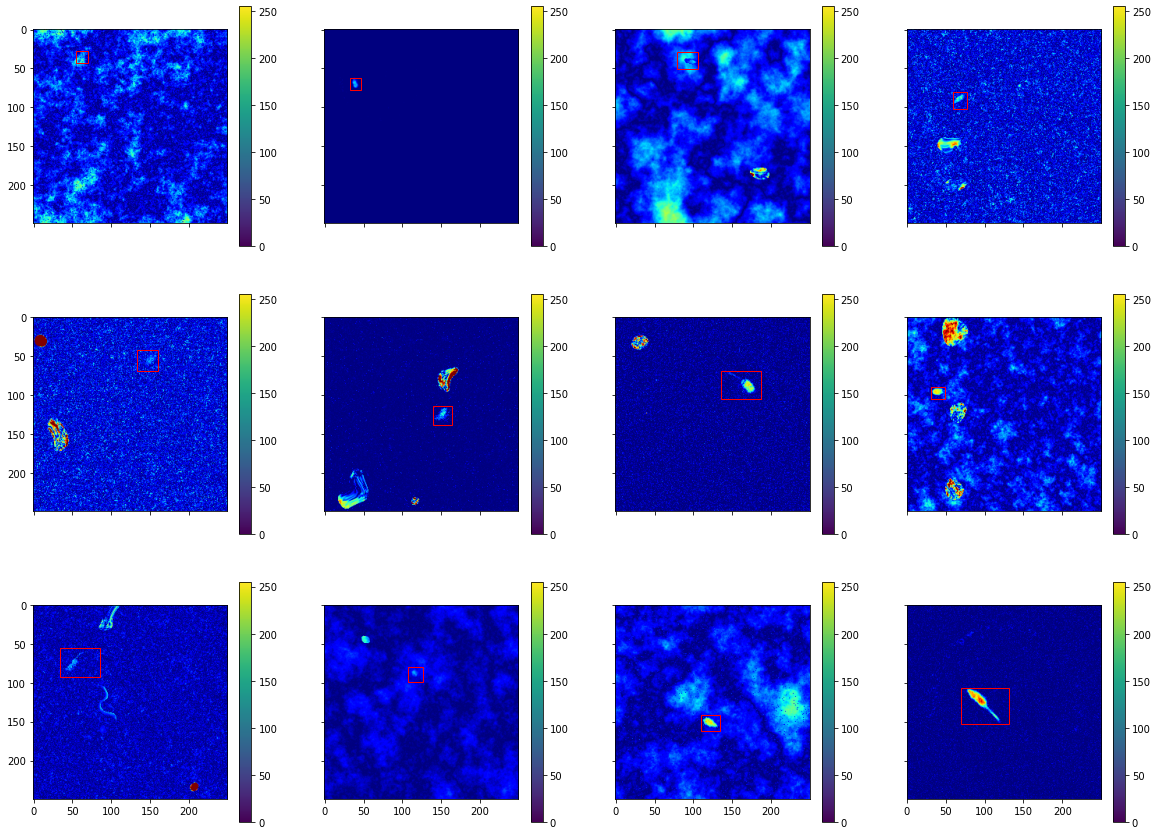

In [15]:
num_images = cfg.SOLVER.IMS_PER_BATCH
vmin = None
vmax = None

fig, axs = plt.subplots(3, num_images // 3, figsize=(20,15), sharex=True, sharey=True)
axs = list(itertools.chain(*axs))

for i, data in enumerate(items):
    idata = np.moveaxis(np.squeeze(data['image'].numpy()), [0], [2])
    #print(idata.min(), idata.max())
    im = axs[i].imshow(idata, vmin=vmin, vmax=vmax)
    for bbox in data['instances'].gt_boxes:
        axs[i].add_patch(Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor='red', facecolor='none'))
    plt.colorbar(im, ax=axs[i])


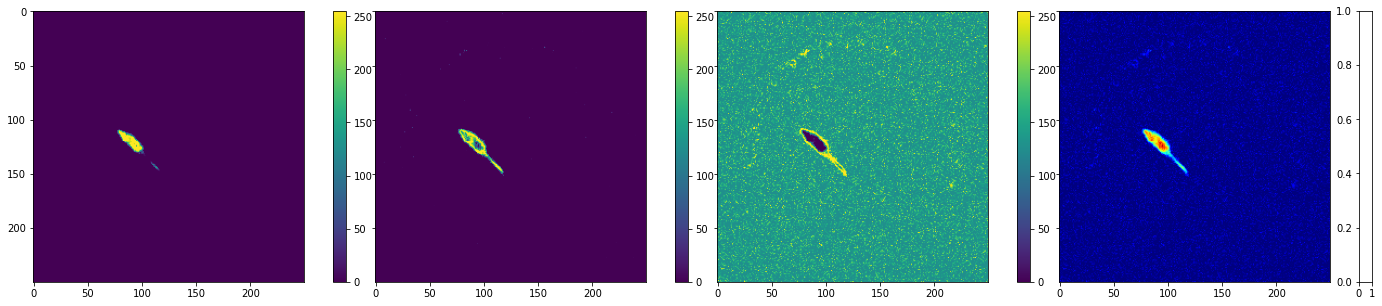

In [27]:
plot_tri_channel(np.moveaxis(np.squeeze(items[11]['image'].numpy()), [0], [2]))

In [ ]:
dir(items[0]['instances'].gt_boxes)

In [3]:
class DoughnutNoiseAugmentation(T.Augmentation):
    def __init__(self, mu: float=0, var_limit=(10.0, 50.0), thickness=(0, 30), weight=0.5, always_apply=False, p=0.5):
        self.mu = mu
        self.thickness = self.validate_range_arg('thickness', thickness)
        self.var_limit = self.validate_range_arg('var_limit', var_limit)
        self.weight = weight
        self.always_apply = always_apply
        self.p_application = p
        
    def validate_range_arg(self, param_name: str, value):
        if isinstance(value, (tuple, list)):
            if value[0] < 0:
                raise ValueError(f"Lower {param_name} should be non negative.")
            if value[1] < 0:
                raise ValueError(f"Upper {param_name} should be non negative.")
            return value
        elif isinstance(var_limit, (int, float)):
            if value < 0:
                raise ValueError(f"{param_name} should be non negative.")

            return (0, value)
        else:
            raise TypeError(
                "Expected var_limit type to be one of (int, float, tuple[int|float], list[int|float]), got {}".format(type(value))
            )
    
    def get_transform(self, image):
        if (random.random() < self.p_application) or self.always_apply:
            # select random values for some parameters
            thickness = random.uniform(self.thickness[0], self.thickness[1])
            var = random.uniform(self.var_limit[0], self.var_limit[1])
            sigma = var ** 0.5
            random_state = np.random.RandomState(random.randint(0, 2 ** 32 - 1))

            xx, yy = np.mgrid[:image.shape[0], :image.shape[1]]
            r_outer = np.max(image.shape[:2]) // 2
            r_inner = r_outer - thickness
            cx = image.shape[0] // 2
            cy = image.shape[1] // 2
            circle = (xx - cx) ** 2 + (yy - cy) ** 2
            donut = np.logical_and(circle < r_outer ** 2, circle > r_inner ** 2)

            im = np.zeros(shape=image.shape[:2], dtype=float)
            im[donut] = random_state.normal(self.mu, sigma, size=np.count_nonzero(donut))
            return T.BlendTransform(im[:,:,None], self.weight, 1-self.weight)
        else:
            return T.NoOpTransform()

124


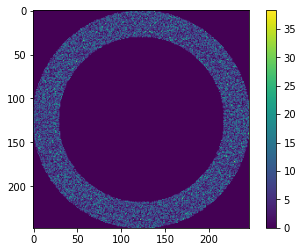

In [61]:

width = 248
height = 246
xx, yy = np.mgrid[:width, :height]
r_outer = width // 2
print(r_outer)
r_inner = r_outer - 30
cx = width // 2
cy = height // 2
circle = (xx - cx) ** 2 + (yy - cy) ** 2
donut = np.logical_and(circle < r_outer ** 2, circle > r_inner ** 2)
        
im = np.zeros(shape=(width, height), dtype=float)
im[donut] = np.abs(np.random.normal(0, 10, size=np.count_nonzero(donut)))
plt.imshow(im)
plt.colorbar()

In [2]:
t = ElasticTransform()

In [3]:
dir(t)

['__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_additional_targets',
 '_get_target_function',
 '_to_dict',
 'add_targets',
 'alpha',
 'alpha_affine',
 'always_apply',
 'applied_in_replay',
 'apply',
 'apply_to_bbox',
 'apply_to_bboxes',
 'apply_to_keypoint',
 'apply_to_keypoints',
 'apply_to_mask',
 'apply_to_masks',
 'apply_with_params',
 'approximate',
 'border_mode',
 'call_backup',
 'deterministic',
 'get_base_init_args',
 'get_class_fullname',
 'get_dict_with_id',
 'get_params',
 'get_params_dependent_on_targets',
 'get_transform_init_args',
 'get_transform_init_args_names',
 'interpolation',
 'is_serializable',
 'mask_value',
 '